<a href="https://colab.research.google.com/github/alexjercan/unsupervised-segmentation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 213kB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 952kB 46.6MB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:

!git clone https://github.com/alexjercan/unsupervised-segmentation.git
%cd unsupervised-segmentation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [2]:
# Download model
torch.hub.download_url_to_file('https://github.com/alexjercan/unsupervised-segmentation/releases/download/v1.0/normal.pth', 'normal.pth')

In [3]:
# Download dataset
torch.hub.download_url_to_file('https://github.com/alexjercan/unsupervised-segmentation/releases/download/v1.0/bdataset_scene.zip', 'tmp.zip')
!unzip -q tmp.zip -d ../ && rm tmp.zip

In [4]:
!bash ./get_bdataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   4434      0 --:--:-- --:--:-- --:--:--  4434
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7494M    0 7494M    0     0  43.0M      0 --:--:--  0:02:54 --:--:-- 23.3M
Completed in 569 seconds


In [5]:
!git pull
!python dataset.py
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
!python model.py
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

Already up to date.
dataset ok
model ok
8558.318359375


In [6]:
import os
import re
import cv2
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_scene"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [
          {"image": "data/0000.png", "depth": "data/0000.exr", "output": "data/out/0000.png"},
          {"image": "data/0001.png", "depth": "data/0001.exr", "output": "data/out/0001.png"},
          {"image": "data/0002.png", "depth": "data/0002.exr", "output": "data/out/0002.png"}
]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 1e-5
BETAS = [0.9, 0.999]
EPS = 1e-8
WEIGHT_DECAY = 1e-4

MILESTONES = [10]
GAMMA = 0.1

NUM_EPOCHS = 20
OUT_PATH ="./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [7]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        M.MyHorizontalFlip(p=0.5),
        M.MyVerticalFlip(p=0.1),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'normal': 'normal',
        'depth': 'depth',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'normal': 'normal',
        'depth': 'depth',
    }
)

detect_transform = A.Compose(
    [
        M.MyLongestMaxSize(max_size=IMAGE_SIZE),
        M.MyPadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'depth' : 'depth',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)

In [16]:
model = Model(num_classes=10, num_layers=3)
model.apply(init_weights)
solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=LEARNING_RATE, betas=BETAS, 
                          eps=EPS, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [17]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print(get_n_params(model))

75530090


In [18]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:3.2518 c:1.1749 s:2.0769)
======SEGMENTATION========
IOU=0.8198	P=0.7673	R=1.0000	F1=0.8672




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:3.0881 c:1.0347 s:2.0533)
======SEGMENTATION========
IOU=0.8534	P=0.8172	R=1.0000	F1=0.8989




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:3.1212 c:1.1421 s:1.9791)
======SEGMENTATION========
IOU=0.8356	P=0.8004	R=1.0000	F1=0.8882




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:3.0792 c:1.0523 s:2.0269)
======SEGMENTATION========
IOU=0.8874	P=0.8651	R=1.0000	F1=0.9273




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:2.9498 c:0.9792 s:1.9706)
======SEGMENTATION========
IOU=0.8967	P=0.8755	R=1.0000	F1=0.9332




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:2.8515 c:1.0927 s:1.7588)
======SEGMENTATION========
IOU=0.9235	P=0.9086	R=1.0000	F1=0.9517




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:2.9170 c:0.9806 s:1.9364)
======SEGMENTATION========
IOU=0.9123	P=0.8964	R=1.0000	F1=0.9449




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:2.8698 c:0.9164 s:1.9533)
======SEGMENTATION========
IOU=0.9046	P=0.8884	R=1.0000	F1=0.9390




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:2.9486 c:1.0326 s:1.9160)
======SEGMENTATION========
IOU=0.9429	P=0.9346	R=1.0000	F1=0.9658




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:2.9296 c:1.0744 s:1.8552)
======SEGMENTATION========
IOU=0.9500	P=0.9432	R=1.0000	F1=0.9707




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:2.8262 c:1.0011 s:1.8251)
======SEGMENTATION========
IOU=0.9536	P=0.9475	R=1.0000	F1=0.9729




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:2.7770 c:0.9744 s:1.8026)
======SEGMENTATION========
IOU=0.9425	P=0.9358	R=1.0000	F1=0.9667




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:2.8099 c:1.0158 s:1.7941)
======SEGMENTATION========
IOU=0.9450	P=0.9382	R=1.0000	F1=0.9679




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:2.7829 c:0.9470 s:1.8359)
======SEGMENTATION========
IOU=0.9493	P=0.9430	R=1.0000	F1=0.9704




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:2.7616 c:0.9399 s:1.8217)
======SEGMENTATION========
IOU=0.9408	P=0.9343	R=1.0000	F1=0.9657




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:2.9724 c:1.0806 s:1.8918)
======SEGMENTATION========
IOU=0.9596	P=0.9544	R=1.0000	F1=0.9765




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:2.8013 c:0.9097 s:1.8916)
======SEGMENTATION========
IOU=0.9305	P=0.9213	R=1.0000	F1=0.9583




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:2.8796 c:0.9918 s:1.8878)
======SEGMENTATION========
IOU=0.9435	P=0.9362	R=1.0000	F1=0.9669




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:2.7711 c:0.8802 s:1.8908)
======SEGMENTATION========
IOU=0.9529	P=0.9459	R=1.0000	F1=0.9719




100%|██████████| 6/6 [00:05<00:00,  1.15it/s, epoch=19, loss=(total:2.7439 c:0.9738 s:1.7701)]

eval_avg_error
Epoch: 19, loss=(total:2.7439 c:0.9738 s:1.7701)
======SEGMENTATION========
IOU=0.9383	P=0.9304	R=1.0000	F1=0.9638




In [19]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

eval_avg_error
Epoch: 19, loss=(total:2.8802 c:1.2032 s:1.6770)
======SEGMENTATION========
IOU=0.9410	P=0.9347	R=1.0000	F1=0.9649




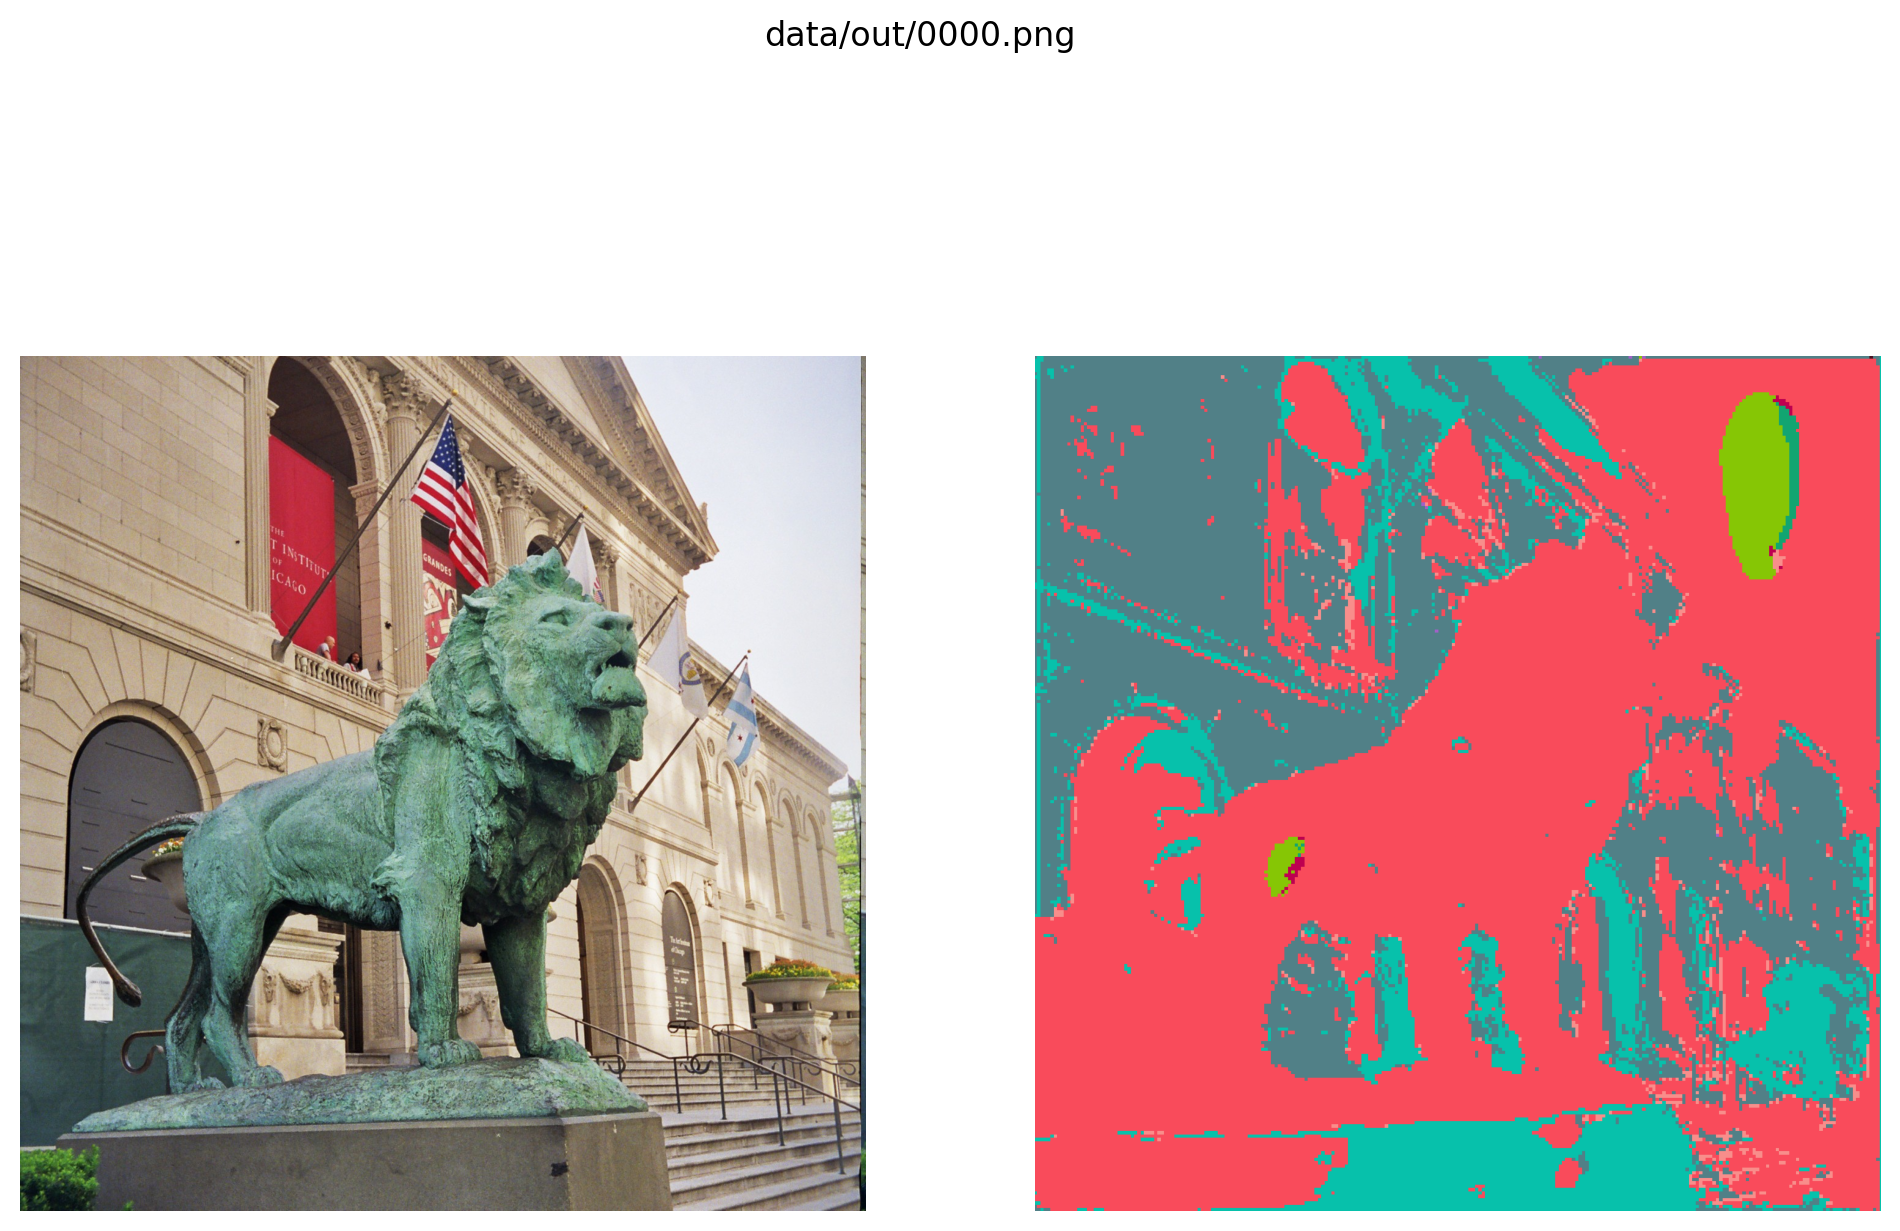

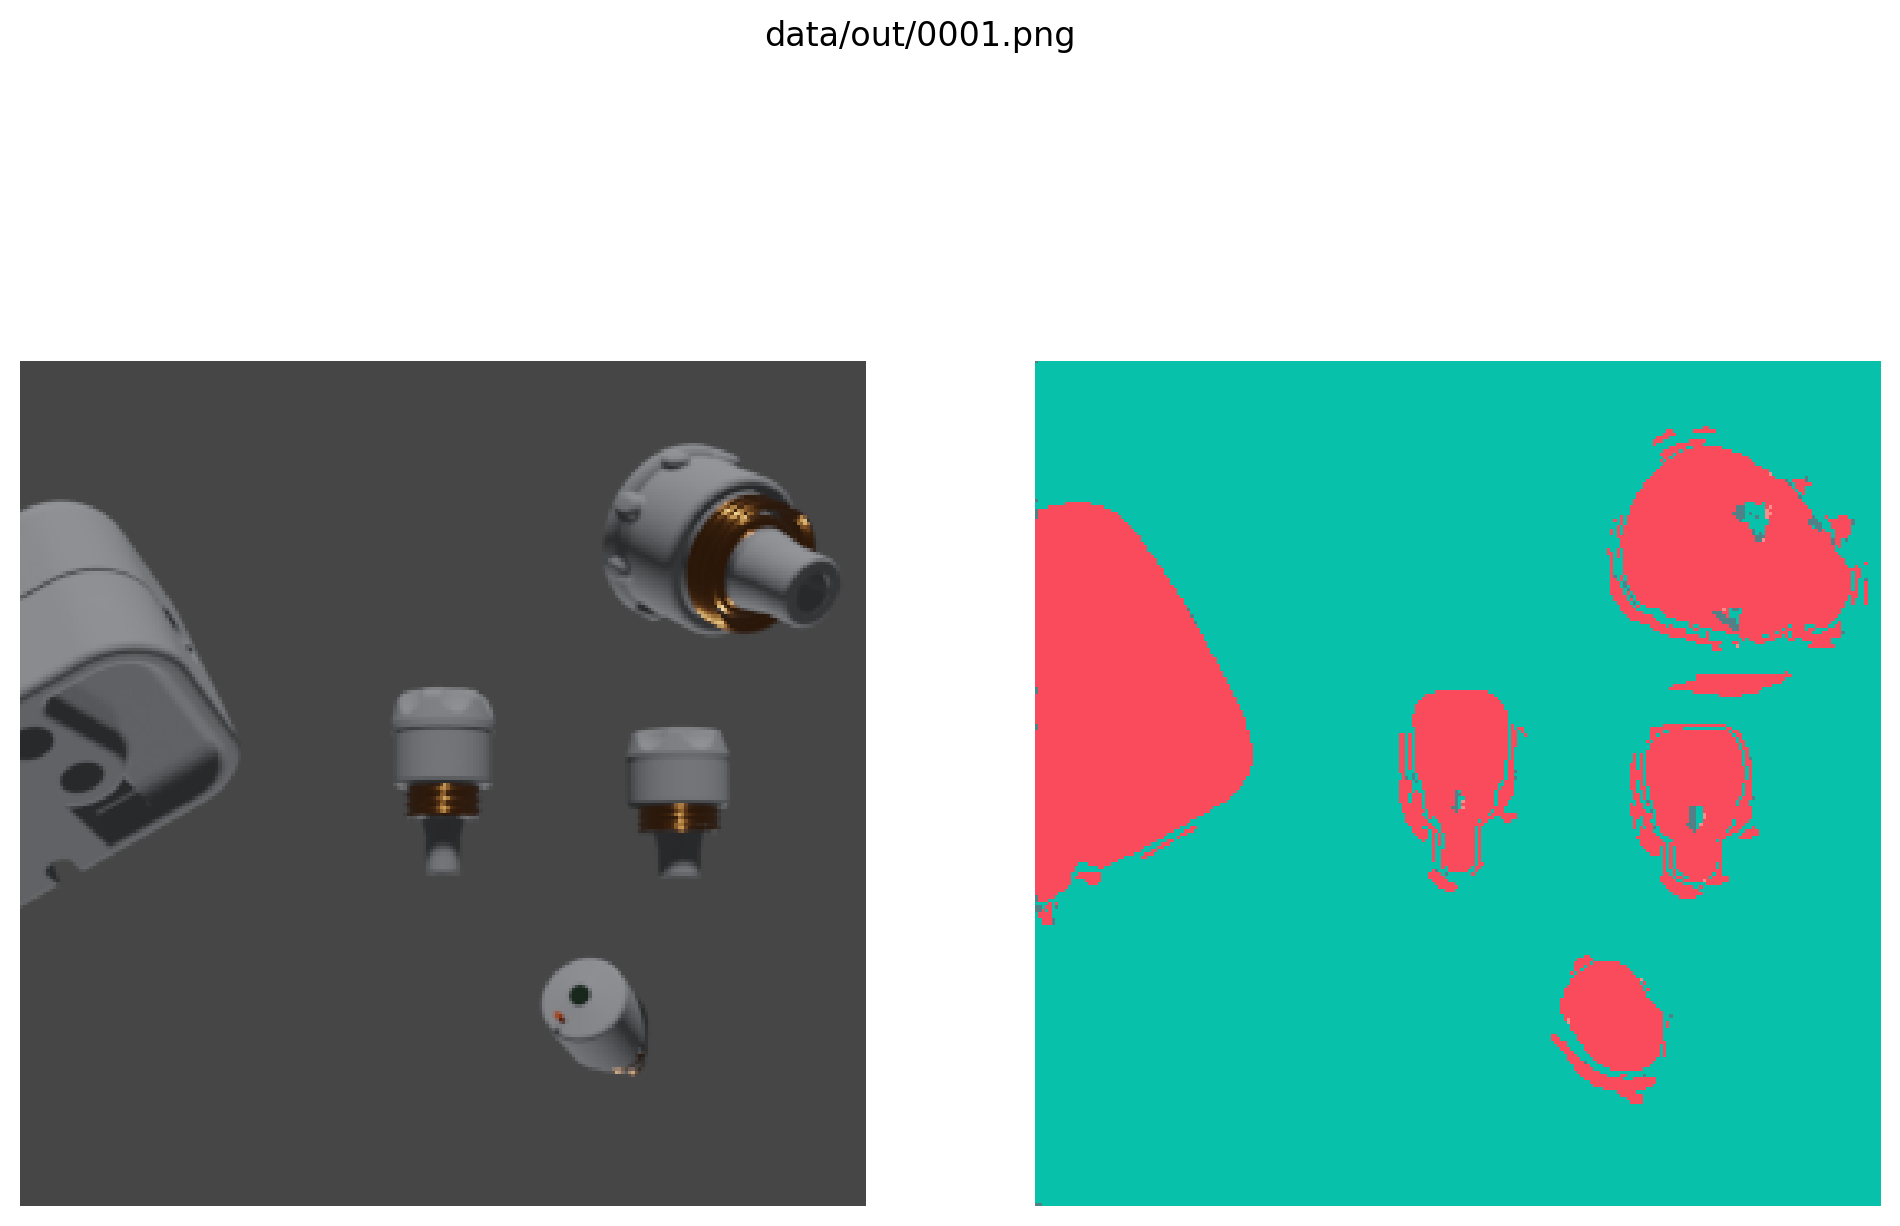

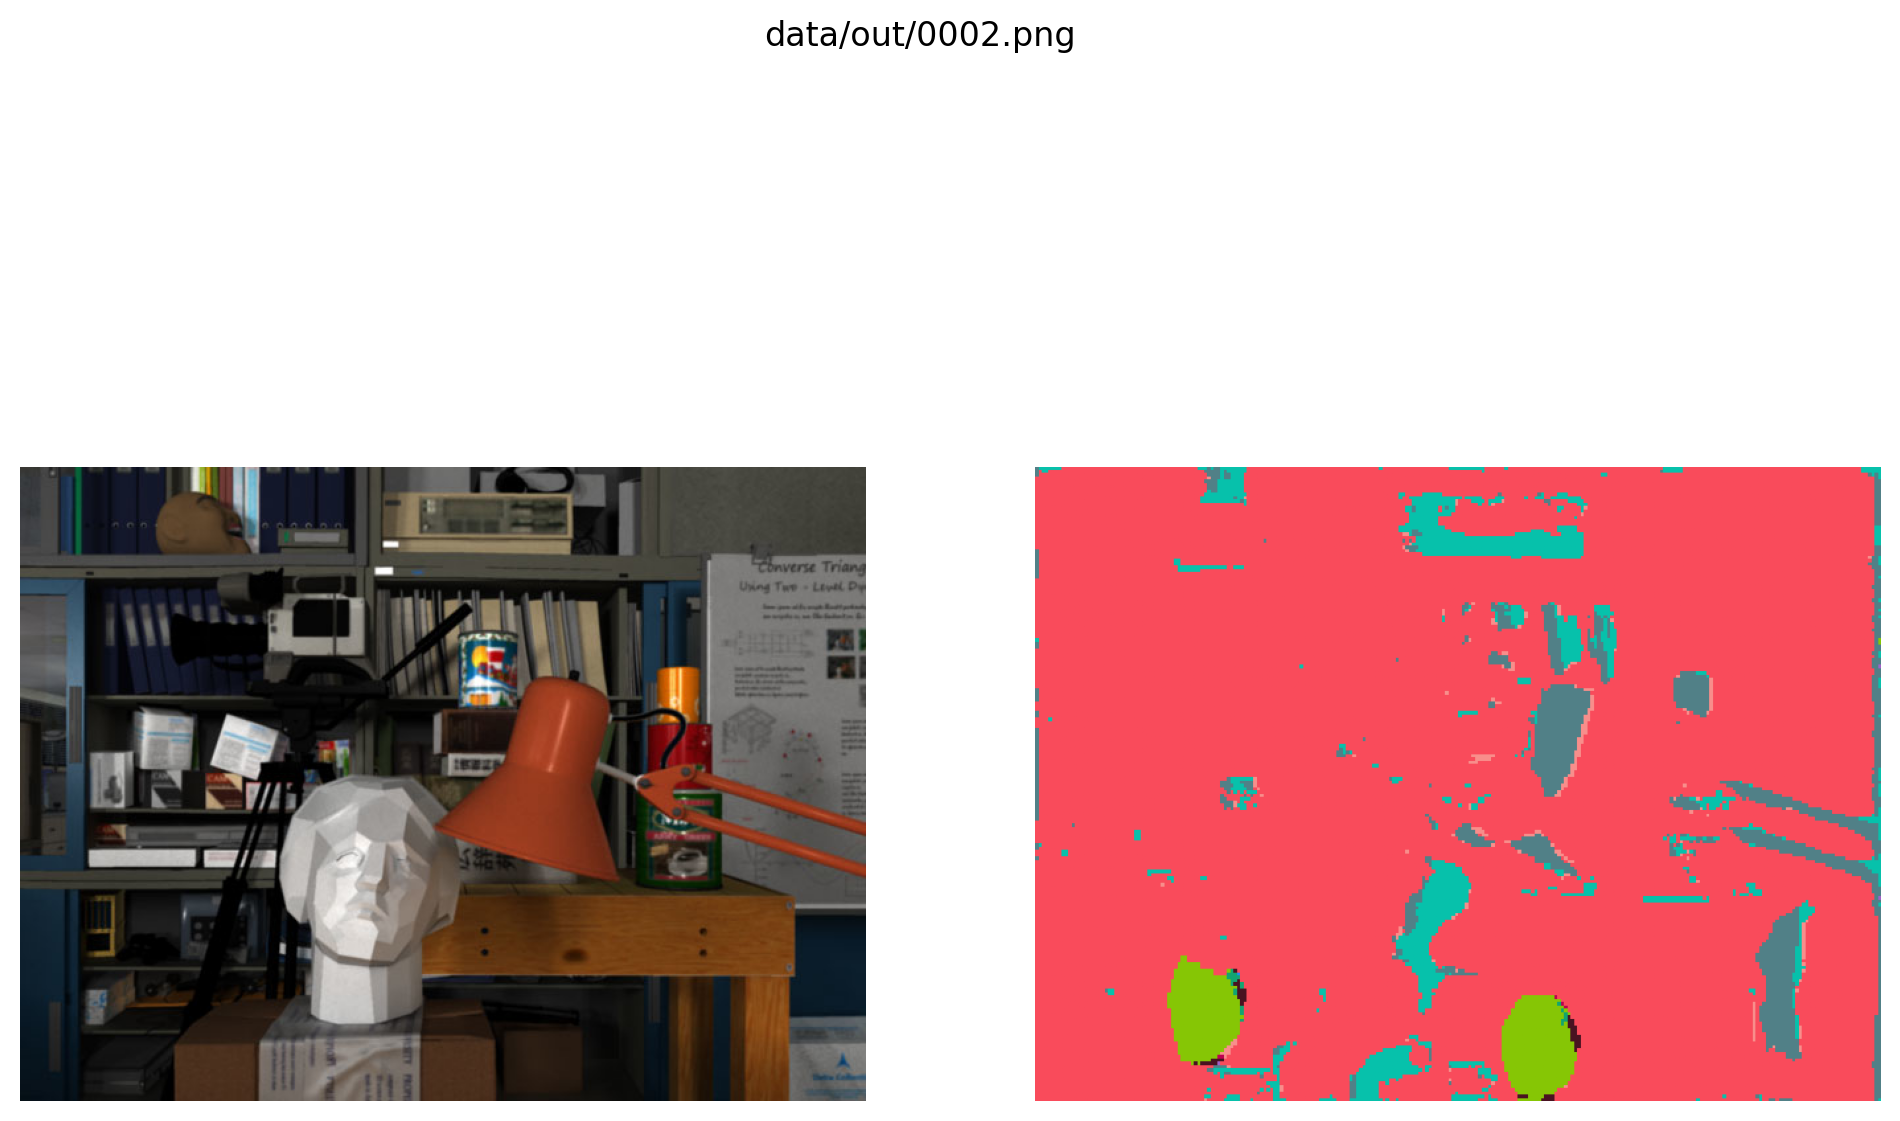

In [23]:
# if LOAD_TEST_MODEL:
epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, depths, path in generatePredictions(model, images):
    plot_predictions([img], predictions, depths, [path])
    save_predictions([img], predictions, depths, [path])

In [22]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)

OG Model kanezaki github

In [8]:
from original import OgModel, OgLossFunction, og_train_one_epoch, og_run_test

In [9]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
!python original.py
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end))

model ok
5404.3642578125


In [10]:
model = OgModel(num_classes=10)
model.apply(init_weights)
solver = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=LEARNING_RATE, momentum=0.9,
                         dampening=0.1, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = OgLossFunction()

In [11]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    og_train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()

  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:2.5157 s:1.2320 c:1.2837)
======SEGMENTATION========
IOU=0.9384	P=0.9384	R=1.0000	F1=0.9676




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:2.4454 s:1.2651 c:1.1804)
======SEGMENTATION========
IOU=0.8802	P=0.8802	R=1.0000	F1=0.9290




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:2.5381 s:1.2778 c:1.2603)
======SEGMENTATION========
IOU=0.9323	P=0.9323	R=1.0000	F1=0.9644




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:2.5210 s:1.3192 c:1.2018)
======SEGMENTATION========
IOU=0.9388	P=0.9388	R=1.0000	F1=0.9681




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:2.4408 s:1.3195 c:1.1213)
======SEGMENTATION========
IOU=0.9327	P=0.9327	R=1.0000	F1=0.9646




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:2.4912 s:1.2898 c:1.2014)
======SEGMENTATION========
IOU=0.9476	P=0.9476	R=1.0000	F1=0.9728




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:2.4934 s:1.2460 c:1.2474)
======SEGMENTATION========
IOU=0.8937	P=0.8937	R=1.0000	F1=0.9418




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:2.4723 s:1.2976 c:1.1748)
======SEGMENTATION========
IOU=0.9509	P=0.9509	R=1.0000	F1=0.9744




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:2.5380 s:1.3636 c:1.1743)
======SEGMENTATION========
IOU=0.9160	P=0.9160	R=1.0000	F1=0.9555




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:2.4324 s:1.3661 c:1.0663)
======SEGMENTATION========
IOU=0.9352	P=0.9352	R=1.0000	F1=0.9659




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:2.5384 s:1.3592 c:1.1793)
======SEGMENTATION========
IOU=0.9499	P=0.9499	R=1.0000	F1=0.9736




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:2.4311 s:1.2582 c:1.1729)
======SEGMENTATION========
IOU=0.9187	P=0.9187	R=1.0000	F1=0.9568




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:2.4794 s:1.2644 c:1.2150)
======SEGMENTATION========
IOU=0.9211	P=0.9211	R=1.0000	F1=0.9583




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:2.5137 s:1.3363 c:1.1774)
======SEGMENTATION========
IOU=0.9343	P=0.9343	R=1.0000	F1=0.9654




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:2.5474 s:1.3921 c:1.1553)
======SEGMENTATION========
IOU=0.9164	P=0.9164	R=1.0000	F1=0.9547




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:2.5135 s:1.3090 c:1.2044)
======SEGMENTATION========
IOU=0.9394	P=0.9394	R=1.0000	F1=0.9681




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:2.4762 s:1.3272 c:1.1489)
======SEGMENTATION========
IOU=0.9259	P=0.9259	R=1.0000	F1=0.9610




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:2.5112 s:1.2840 c:1.2273)
======SEGMENTATION========
IOU=0.9175	P=0.9175	R=1.0000	F1=0.9563




  0%|          | 0/6 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:2.5347 s:1.3064 c:1.2283)
======SEGMENTATION========
IOU=0.9166	P=0.9166	R=1.0000	F1=0.9563




100%|██████████| 6/6 [00:01<00:00,  3.06it/s, epoch=19, loss=(total:2.4507 s:1.3241 c:1.1266)]

eval_avg_error
Epoch: 19, loss=(total:2.4507 s:1.3241 c:1.1266)
======SEGMENTATION========
IOU=0.9039	P=0.9039	R=1.0000	F1=0.9459




In [12]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
og_run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

eval_avg_error
Epoch: 19, loss=(total:2.6606 s:1.2141 c:1.4464)
======SEGMENTATION========
IOU=0.8861	P=0.8861	R=1.0000	F1=0.9339


